# Kaggle - House Prices: Advanced Regression Techniques

## Overview

Developing a machine learning model to predict housing prices from the wide array of features in the [Ames Housing dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). The metric used for evaluation will be the Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price.

Applying lessons from [Kaggle machine learning tutorial](https://www.kaggle.com/learn/maching_learning), (see levels_1_2.ipynb for completed tutorial), [Hands-On Machine Learning](https://github.com/ageron/handson-ml) and other sources.

## Project Brainstorm:

1. Review tutorial
2. Categorical pipeline / pipeline merging
3. Regularization
4. Feature analysis
5. Correlations
6. Additional models
...

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
plt.style.use('default')
np.random.seed(42)
pd.set_option('max_rows', 9)
pd.set_option('max_columns', 100)
pd.options.display.float_format = '{:,.3f}'.format

## Data exploration

In [99]:
# Loading training and test data provided by Kaggle
train_raw = pd.read_csv('data/train.csv', index_col='Id')
test_raw = pd.read_csv('data/test.csv', index_col='Id')

# Training data (rows, columns)
print('train:', train_raw.shape)
print('test:', test_raw.shape)

# Training data potential feature list
print(train_raw.columns)

# Check that test data features are same as training without SalePrice
print((test_raw.columns == train_raw.drop('SalePrice', axis=1).columns).all())

train: (1460, 80)
test: (1459, 79)
Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'Ga

### Notes

* Kaggle Data
  + Training and testing data are provided 
  + Split is roughly 50/50 
  + Test data do not include SalePrice

In [4]:
# Summary statistics for numerical training data
with pd.option_context('max_rows', None):
    display(train_raw.describe().T)

,count,mean,std,min,25%,50%,75%,max
MSSubClass,"1,460.000",56.897,42.301,20.000,20.000,50.000,70.000,190.000
LotFrontage,"1,201.000",70.050,24.285,21.000,59.000,69.000,80.000,313.000
LotArea,"1,460.000","10,516.828","9,981.265","1,300.000","7,553.500","9,478.500","11,601.500","215,245.000"
OverallQual,"1,460.000",6.099,1.383,1.000,5.000,6.000,7.000,10.000
OverallCond,"1,460.000",5.575,1.113,1.000,5.000,5.000,6.000,9.000
YearBuilt,"1,460.000","1,971.268",30.203,"1,872.000","1,954.000","1,973.000","2,000.000","2,010.000"
YearRemodAdd,"1,460.000","1,984.866",20.645,"1,950.000","1,967.000","1,994.000","2,004.000","2,010.000"
MasVnrArea,"1,452.000",103.685,181.066,0.000,0.000,0.000,166.000,"1,600.000"
BsmtFinSF1,"1,460.000",443.640,456.098,0.000,0.000,383.500,712.250,"5,644.000"
BsmtFinSF2,"1,460.000",46.549,161.319,0.000,0.000,0.000,0.000,"1,474.000"


In [5]:
# Training vs test data
  # Quick relative difference metric for numerical attributes
rel_diff = np.abs((test_raw.describe().loc['mean', :] - 
                   train_raw.describe().loc['mean', :]) /
                  ((test_raw.describe().loc['mean', :] +
                    train_raw.describe().loc['mean', :]) / 2))

rel_diff.loc[rel_diff > 0.2].sort_values(ascending=False)

3SsnPorch      0.621
LowQualFinSF   0.490
PoolArea       0.451
MiscVal        0.289
Name: mean, dtype: float64

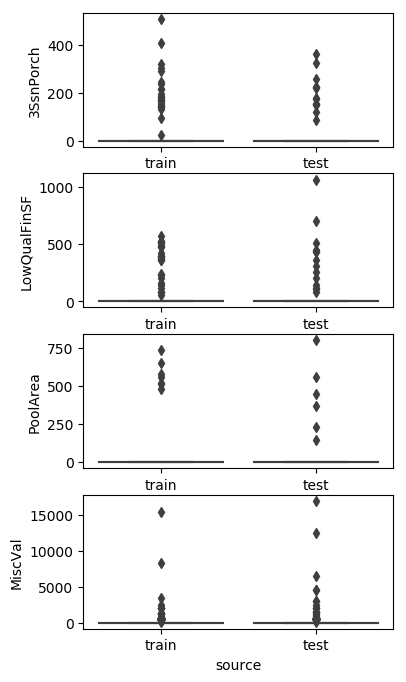

In [98]:
cols = ['3SsnPorch', 'LowQualFinSF', 'PoolArea', 'MiscVal'] 

fig, axarr = plt.subplots(len(cols), 1, figsize=(4, len(cols)*2))

for idx, col in enumerate(cols):
    sns.boxplot(x='source', y=col, data=
                pd.concat([(train_raw.loc[:, col:col].assign(source='train')),
                           (test_raw.loc[:, col:col].assign(source='test'))]),
                ax=axarr[idx]) 
plt.show()


    Notes: 
    * Features seem generally well split between training and test sets
    * A few features with modes of 0 and large outliers could present some difficulty
      '3SsnPorch', 'LowQualFinSF', 'PoolArea', 'MiscVal' 

### Notes
* Train vs Test stratification
  + Features seem generally well split as provided
  + A few features with modes of 0 and large outliers could present some difficulty
    * '3SsnPorch', 'LowQualFinSF', 'PoolArea', 'MiscVal'
    * Might convert to yes/no or drop entirely if metric per SF seems overfit
    * All four appear have weak correlation with SalesPrice (see correlations below)

In [6]:
# Summary statistics for categorical training data
with pd.option_context('max_rows', None):
    display(test_raw.select_dtypes(include='object').describe().T)

,count,unique,top,freq
MSZoning,1455,5,RL,1114
Street,1459,2,Pave,1453
Alley,107,2,Grvl,70
LotShape,1459,4,Reg,934
LandContour,1459,4,Lvl,1311
Utilities,1457,1,AllPub,1457
LotConfig,1459,5,Inside,1081
LandSlope,1459,3,Gtl,1396
Neighborhood,1459,25,NAmes,218
Condition1,1459,9,Norm,1251


In [7]:
# Columns with NAs 
#   Number of NA enteries, Proportion of NAs, dtype of column
with pd.option_context('max_rows', None):
    (display
     (train_raw.isnull().sum().loc[train_raw.isnull().sum() > 0]
      .sort_values(ascending=False)
      .to_frame(name = 'NAs')
      .assign(Prop_NA = lambda srs: (srs['NAs']) / len(train_raw))
      .join
       (train_raw.loc[:, train_raw.count() < len(train_raw)]
        .dtypes
        .to_frame(name='dtype')
       )
     )
    )

,NAs,Prop_NA,dtype
PoolQC,1453,0.995,object
MiscFeature,1406,0.963,object
Alley,1369,0.938,object
Fence,1179,0.808,object
FireplaceQu,690,0.473,object
LotFrontage,259,0.177,float64
GarageYrBlt,81,0.055,float64
GarageType,81,0.055,object
GarageFinish,81,0.055,object
GarageQual,81,0.055,object


### Notes

* NAs often indicate none here (feature not present) not missing data
  + LotFrontage: NA = zero <br> 
    * these are lots that only contact streets by a driveway<br><br>
    
  + GarageYrBlt: NA = no garage<br>
    * zero would not make sense for the year built<br>
    * not sure how to best assign a year for no-garage???
    * no garage information also included in GarageType feature

In [8]:
# Examining MasVnrType
  # Difference between Na and None
display((train_raw[['MasVnrArea', 'MasVnrType']]
 .loc[train_raw['MasVnrArea'] == 0]
 .sort_values(by='MasVnrArea')))

(train_raw[['MasVnrArea', 'MasVnrType']]
 .loc[train_raw['MasVnrArea'].isnull()]
 .sort_values(by='MasVnrArea'))

,MasVnrArea,MasVnrType
Id,,
2,0.000,None
973,0.000,None
975,0.000,None
976,0.000,None
...,...,...
502,0.000,None
503,0.000,None
505,0.000,None
1460,0.000,None


,MasVnrArea,MasVnrType
Id,,
235,nan,NaN
530,nan,NaN
651,nan,NaN
937,nan,NaN
974,nan,NaN
978,nan,NaN
1244,nan,NaN
1279,nan,NaN


### Note

* Unclear what the difference between Masonry veneer none and NA???
  + MasVnrArea nan = 0
  + MasVnrType NaN = None

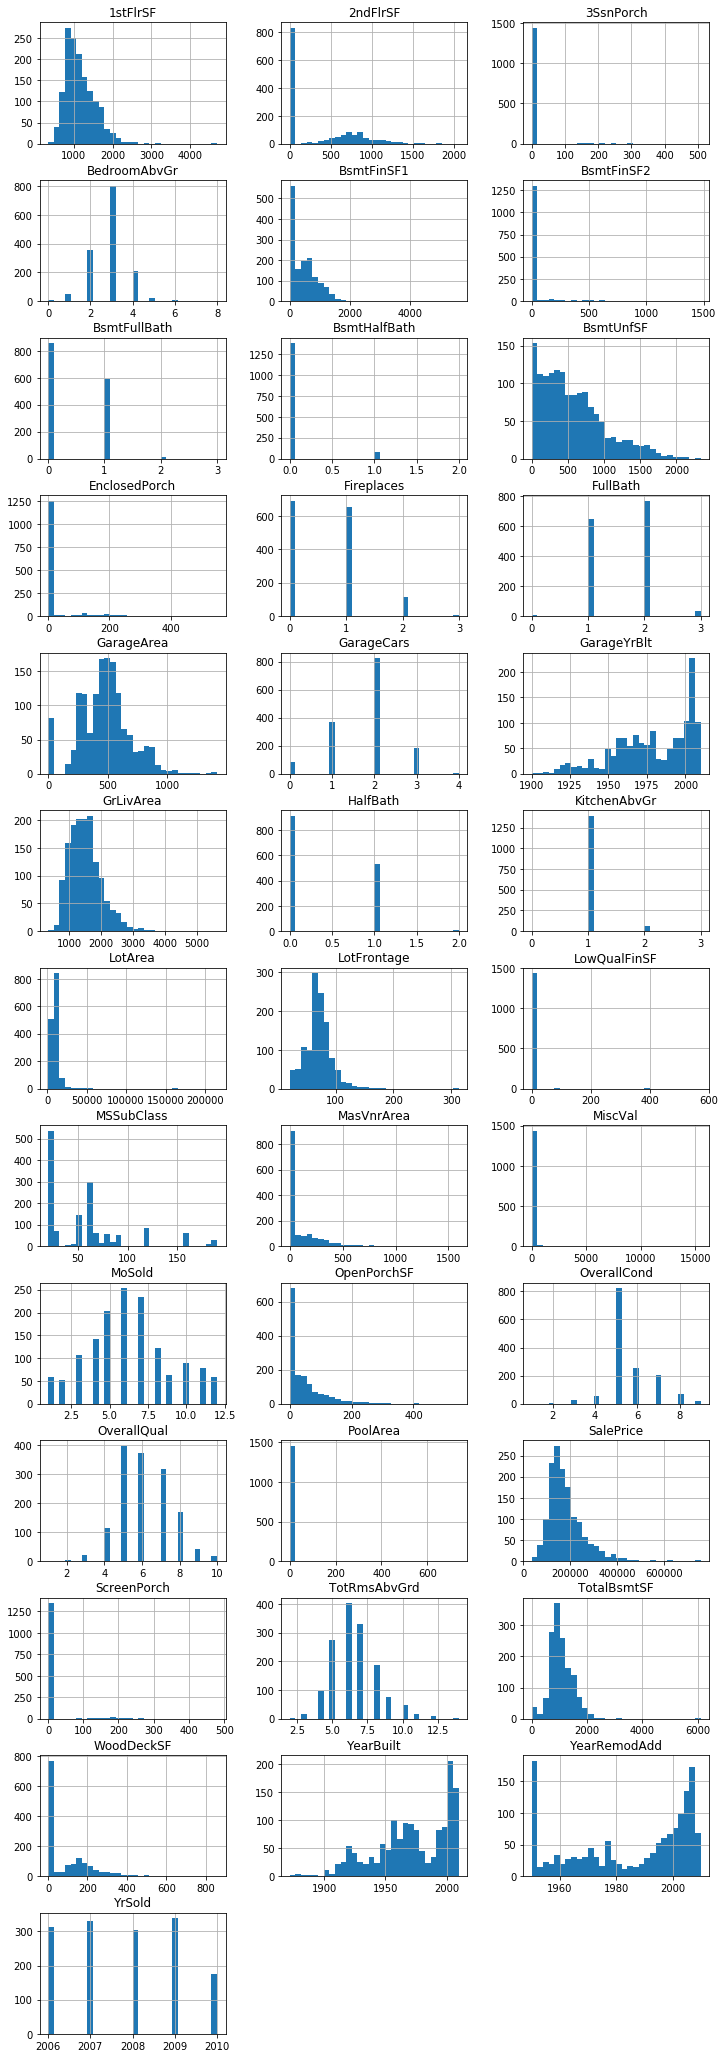

In [9]:
# Rough histograms of numerical features
n_num = train_raw.select_dtypes(exclude='object').shape[1]
train_raw.hist(figsize=(12, n_num), bins=30, 
               layout=(int(np.ceil(n_num / 3)), 3))
plt.show()

### Notes

* Possible issues / solutions
  + How to handle possible non-linear relationships???
    * Add or convert features???
      1stFlrSF -> log(1stFlrSF)  
    * Add or convert numeric any to yes/no or multiple categories???<br>
      Fireplaces -> Fireplace, 2nd Fireplace, 3+ Fireplace
      <br><br>
      
  + How to handle highly correlated features???
     * Drop one???
     * Examples
       + 2nfFlrSF=0 shows up in HouseStyle
       + GarageArea to GarageCars
       + SF to TotRmsAbvGrd to BedRoomAbvGr
       + 1stFlrSF + 2ndFlrSF = GrLivArea ???
       + BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSf = TotalBsmtSF ???
       <br><br>
     
  + How to handle features that are largely 0 or NA???
      * Combine BsmtFinSF2 with BsmtFinSF1???
      <br><br>
      
  + Treatment of ordinal variables???
    * Ordinal as categorical - loses information
    * Ordinal as numeric - makes assumption that intervals are equal

    * OverallQual and OverallCond are numeric by default, may change to categorical
      OverallQual correlates highly with SalePrice and may be significant cost to
      convert to categorical
    
    * ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1,
    BsmtFinType2, HeatingQC, KitchenQual, FireplaceQu, GarageQual, GarageCond,
    PoolQC, Fence - are all categorical by default but could be converted to numeric
<br><br>
* Convert to categorical
  + MSSubClass is a numeric code -> convert to categorical
<br><br>
* YearRemodAdd spike at 1950 
  + info says same as construction date if no remodel, but spike at 1950
    it seems that data for remodeling before 1950 was not available 
    and was recorded as a 1950 remodeling (see cell below) 
    seems okay, could also try assuming no remodel or an average date

In [100]:
# Exploring spike in YearRemodAdd at 1950
train_raw[['YearBuilt', 'YearRemodAdd']]

# Test if any houses where built before remodeling (per the data)
print((train_raw['YearBuilt'] > train_raw['YearRemodAdd']).any())

# Test if any houses built before 1950 were remodeled in a year other than 1950
display(train_raw[['YearBuilt', 'YearRemodAdd']]
 .loc[(train_raw['YearBuilt'] < 1950) & (train_raw['YearRemodAdd'] < 1950)]
 .sort_values(by='YearRemodAdd')
)

display(train_raw[['YearBuilt', 'YearRemodAdd']]
 .loc[(train_raw['YearBuilt'] < 1950) & (train_raw['YearRemodAdd'] == 1950)]
 .sort_values(by='YearRemodAdd')
)

display(train_raw[['YearBuilt', 'YearRemodAdd']]
 .loc[(train_raw['YearBuilt'] < 1950) & (train_raw['YearRemodAdd'] > 1950)]
 .sort_values(by='YearRemodAdd')
)

False


,YearBuilt,YearRemodAdd
Id,,


,YearBuilt,YearRemodAdd
Id,,
9,1931,1950
1029,1941,1950
1035,1938,1950
1060,1932,1950
...,...,...
564,1918,1950
566,1915,1950
577,1928,1950
1444,1916,1950


,YearBuilt,YearRemodAdd
Id,,
936,1926,1953
269,1940,1955
977,1923,1958
1333,1938,1958
...,...,...
1386,1922,2007
49,1920,2008
1124,1947,2008
293,1949,2008


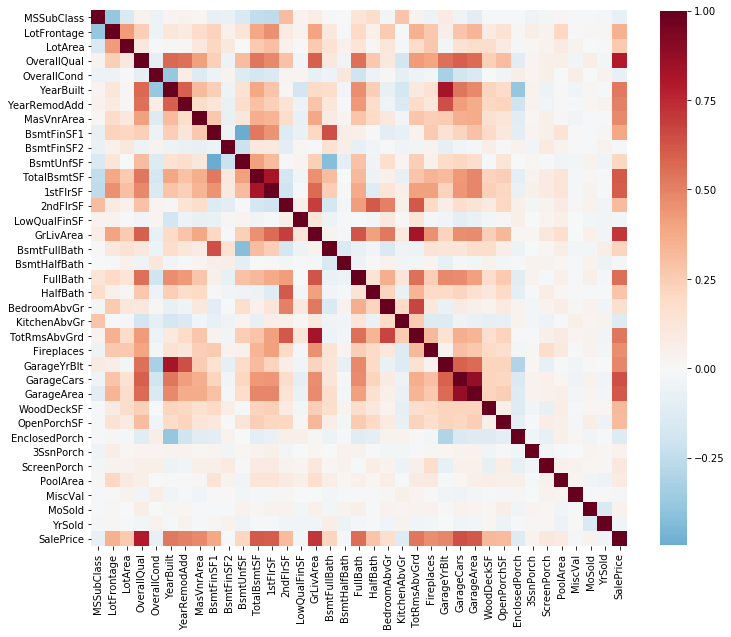

In [11]:
# Numerical Feature Correlations
fig = plt.figure(figsize=(12, 12))
ax = sns.heatmap(train_raw.corr(),
                 annot=False,
                 cmap='RdBu_r',
                 center=0,
                 cbar_kws={'shrink':0.82}  # Rough match to axis scaling below
                )
ax.axis('scaled')  # equal x and y increments 
plt.show()

### Notes

* Interesting???
  + OverallQual correlates with almost everything, particularly with Sale Price
  + OverallCond weekly anti correlated with almost everything, but 
    * Looks like "5" may have been used as a default (see below).<br>
      + If so it might be possible to make use of information in non-"5"s by replacing
        "5"s with learned values from other data<br>
      + Alternatively most houses are 5 and feature may not be particularly useful

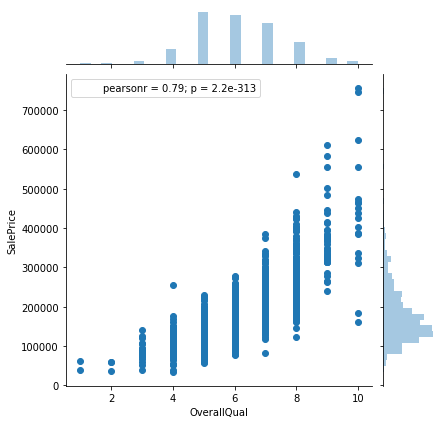

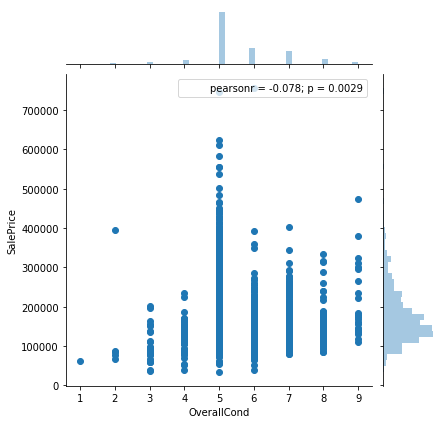

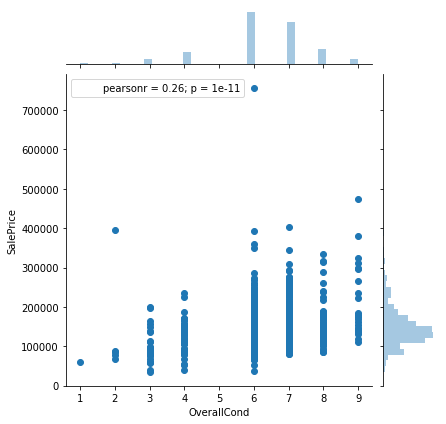

In [12]:
sns.jointplot(x='OverallQual', y='SalePrice', data=train_raw)
sns.jointplot(x='OverallCond', y='SalePrice', data=train_raw)
sns.jointplot(x='OverallCond', y='SalePrice', 
              data=train_raw.loc[train_raw['OverallCond'] != 5])

In [13]:
# Numerical features correlation with Sale Price

with pd.option_context('max_rows', None):
    display(train_raw.corr().loc[:, ['SalePrice']].sort_values(by='SalePrice'))

# Plot as heatmap
if False:
    fig = plt.figure(figsize=(12, 24))
    ax = sns.heatmap(train_raw.corr()
                              .loc[:, ['SalePrice']]
                              .sort_values(by='SalePrice'),
                     annot=True,
                     cmap='RdBu_r',
                     center=0,
                     cbar=False,
                     cbar_kws={'shrink':0.82}  # Rough match to axis scaling below
                    )
    ax.axis('scaled')  # equal x and y increments 
    plt.show()

,SalePrice
KitchenAbvGr,-0.136
EnclosedPorch,-0.129
MSSubClass,-0.084
OverallCond,-0.078
YrSold,-0.029
LowQualFinSF,-0.026
MiscVal,-0.021
BsmtHalfBath,-0.017
BsmtFinSF2,-0.011
3SsnPorch,0.045


In [14]:
def calc_area_diff(df):
    df = df.copy()
    df['AreaDiff'] = (df['GrLivArea'] -  
                      (df['1stFlrSF'] + df['2ndFlrSF'] + df['LowQualFinSF']))
    return df

def screen_area_diff(df):
    return df.loc[df['AreaDiff'] != 0]

(train_raw[['GrLivArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF']]
 .pipe(calc_area_diff)
 .pipe(screen_area_diff)
)

,GrLivArea,1stFlrSF,2ndFlrSF,LowQualFinSF,AreaDiff
Id,,,,,


In [15]:
def calc_bsmtarea_diff(df):
    df = df.copy()
    df['BsmtAreaDiff'] = (df['TotalBsmtSF'] -  
                      (df['BsmtFinSF1'] + df['BsmtFinSF2'] 
                       + df['BsmtUnfSF']))
    return df

def screen_bsmtarea_diff(df):
    return df.loc[df['BsmtAreaDiff'] != 0]

(train_raw[['TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']]
 .pipe(calc_bsmtarea_diff)
 .pipe(screen_bsmtarea_diff)
)

,TotalBsmtSF,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,BsmtAreaDiff
Id,,,,,


### Note

* Checking SF / Area sums
  + GrLivArea is 1stFlrSF + 2ndFlrSF + LowQualFinSF 
  + TotalBsmtSF is BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF

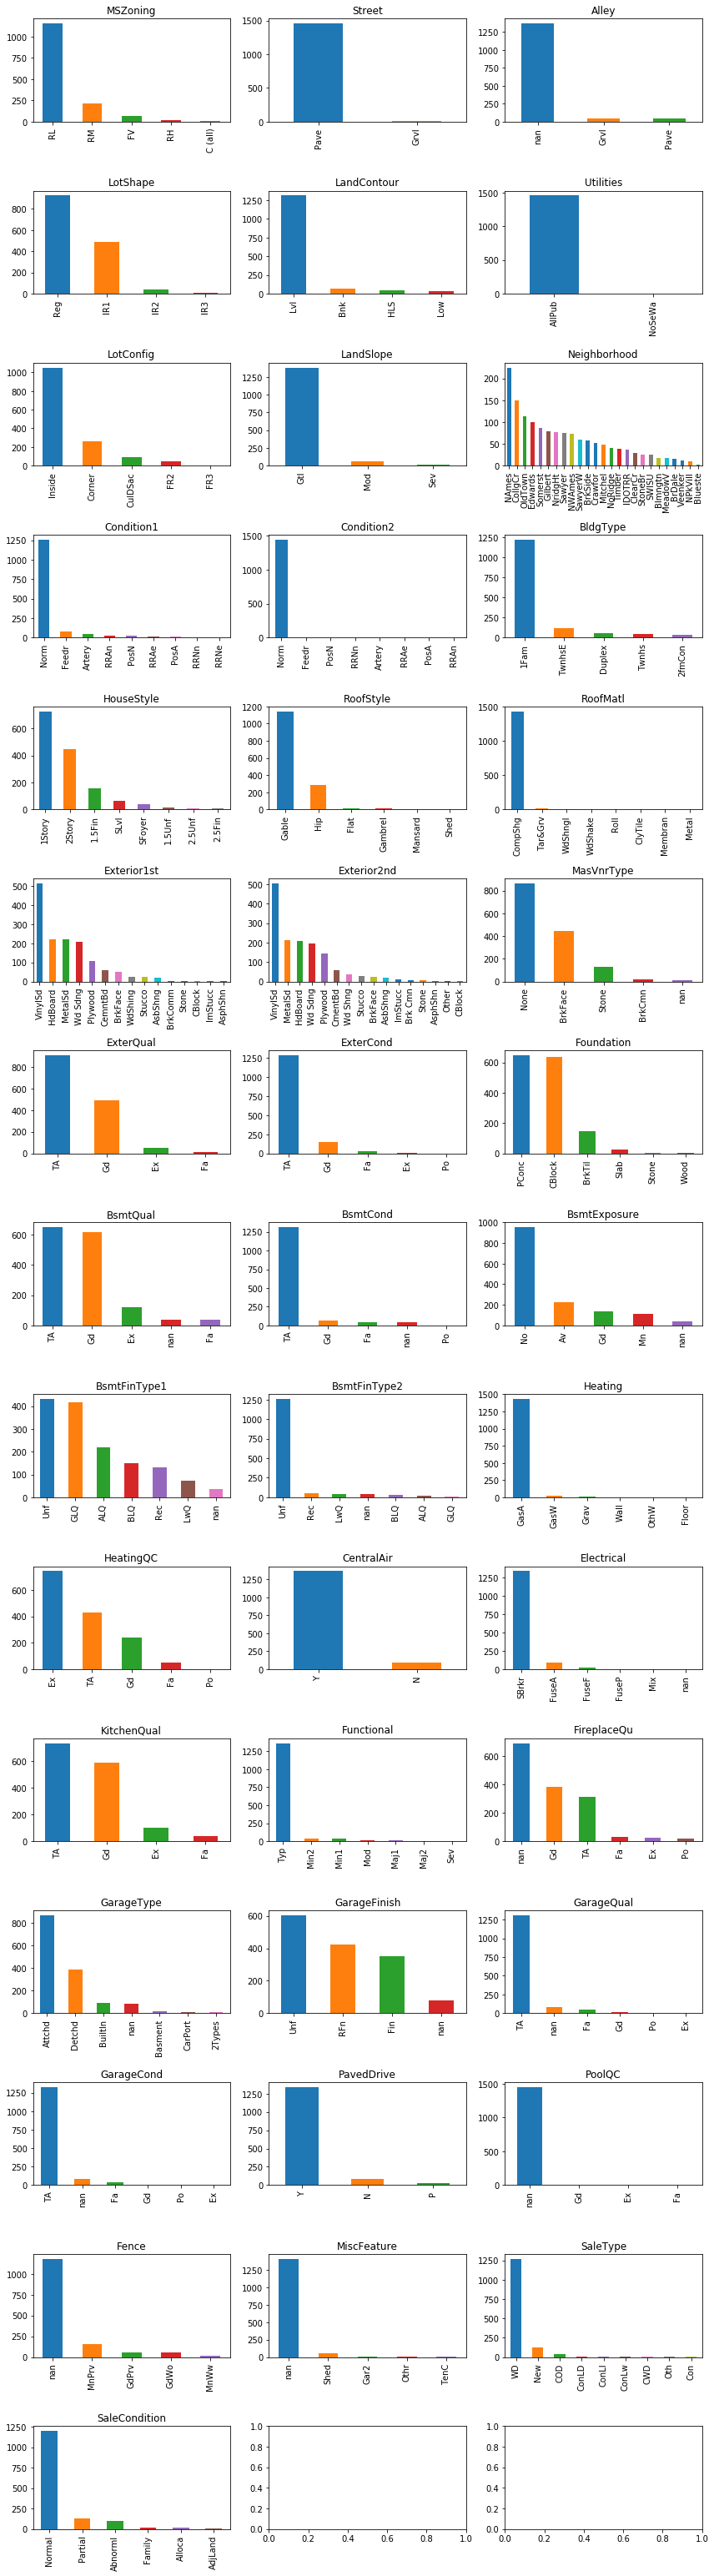

In [16]:
# Rough count plots of categorical features
n_cat = train_raw.select_dtypes(include='object').shape[1]

fig, ax = plt.subplots(int(np.ceil(n_cat / 3)), 3, figsize=(12, n_cat))
i = 0
j = 0

for col in train_raw.select_dtypes(include='object').columns:
    #sns.countplot(train_raw[col], ax=ax[i, j])
    train_raw[col].value_counts(dropna=False).plot.bar(ax=ax[i, j])
    ax[i, j].set_title(col)
    
    if j == 2:
        j = 0
        i += 1
    else:
        j += 1
    
plt.tight_layout()
plt.show()


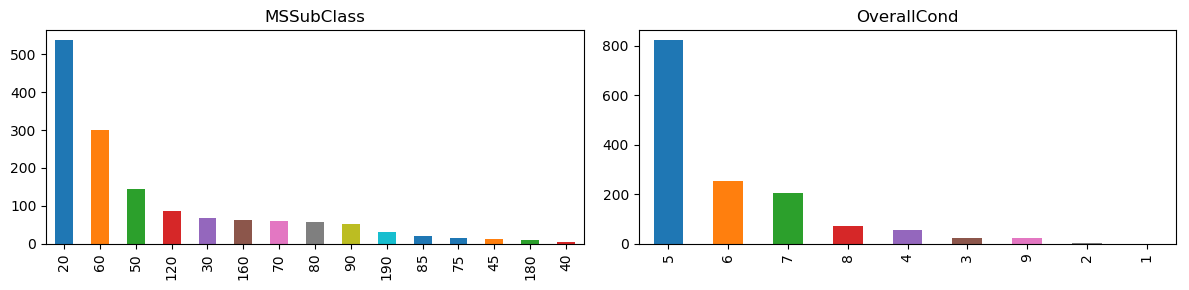

In [101]:
# Categorical converted from numeric
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

train_raw['MSSubClass'].value_counts(dropna=False).plot.bar(ax=ax[0])
ax[0].set_title('MSSubClass')
train_raw['OverallCond'].value_counts(dropna=False).plot.bar(ax=ax[1])
ax[1].set_title('OverallCond')
    
plt.tight_layout()
plt.show()

### Notes

* Many categorical features class imbalance
 
* Condition1 and Condition2 features
  + Condition2 extremely rare
  + technically should probably be "two"-hot encoded (that is instead of a second set of features for Condition2, it should change a False to True in the set of features from Condition1)

* Exterior1st and Exterior2nd features
  + Looks like Exterior1st is repeated if not different
  + Looks like Exterior2nd is almost never different

## Data preparation

In [ ]:
train_x = train_raw.drop('SalePrice', axis=1)
train_y = train_raw['SalePrice']

In [ ]:
# Datatype conversions

# Convert MSSubClass to string for use as nominal, categorical feature
train_x['MSSubClass'] = train_x['MSSubClass'].astype(str)

# Convert OverallCond to string 
#   unusual frequency of 5s, but other values seem meaningful (see data exploration)
train_x['OverallCond'] = train_x['OverallCond'].astype(str)

# Keeping OverallQual as numeric (for now)
#   to keep high correlation with SalesPrice (see data exploration)
#   may opt to change if assumption of linear differences is too far off 

# Keeping other ordinal features as categorical (for now)
#   to ensure differences in rankings are not overstated
#   (see data exploration)

In [ ]:
# Two-hot encoding?

# Condition1 and Condition2

# Exterior1st and Exterior2nd 

In [ ]:
train_y